In [205]:
#Fill these file paths with the locations on your machine. 
PATH_TO_CODE = 'C:/Users/blake/OneDrive/Desktop/Computer Vision/Project/pastis-benchmark/code' # path to the code folder of the repo
PATH_TO_PASTIS = 'D:/PASTIS'


import sys
sys.path.append(PATH_TO_CODE)


import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.colormaps['tab20']
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_rgb_from_np(im):
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_radar(x, batch_index=0, t_show=6, orbit='D'):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x['S1{}'.format(orbit)][batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [206]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTIS, norm=True, target='semantic')
# If you only need to evaluate semantic segmentation use target='semantic'

dl = torch.utils.data.DataLoader(dt, batch_size=10, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .
Done.
Dataset ready.


In [207]:
# Loading a batch from the dataloader
(x, dates), y = dl.__iter__().__next__()

# x is a dictionary thay contains the Sentinel-2 time series
# in the 'S2' key, shape: B x T x C x H x W
print(x.keys())
print(x['S2'].shape)
# dates contains the observation dates of each image, shape: B x T
print(dates['S2'].shape)

print(y.shape)

dict_keys(['S2'])
torch.Size([10, 61, 10, 128, 128])
torch.Size([10, 61])
torch.Size([10, 128, 128])


Text(0.5, 1.0, 'Semantic labels.')

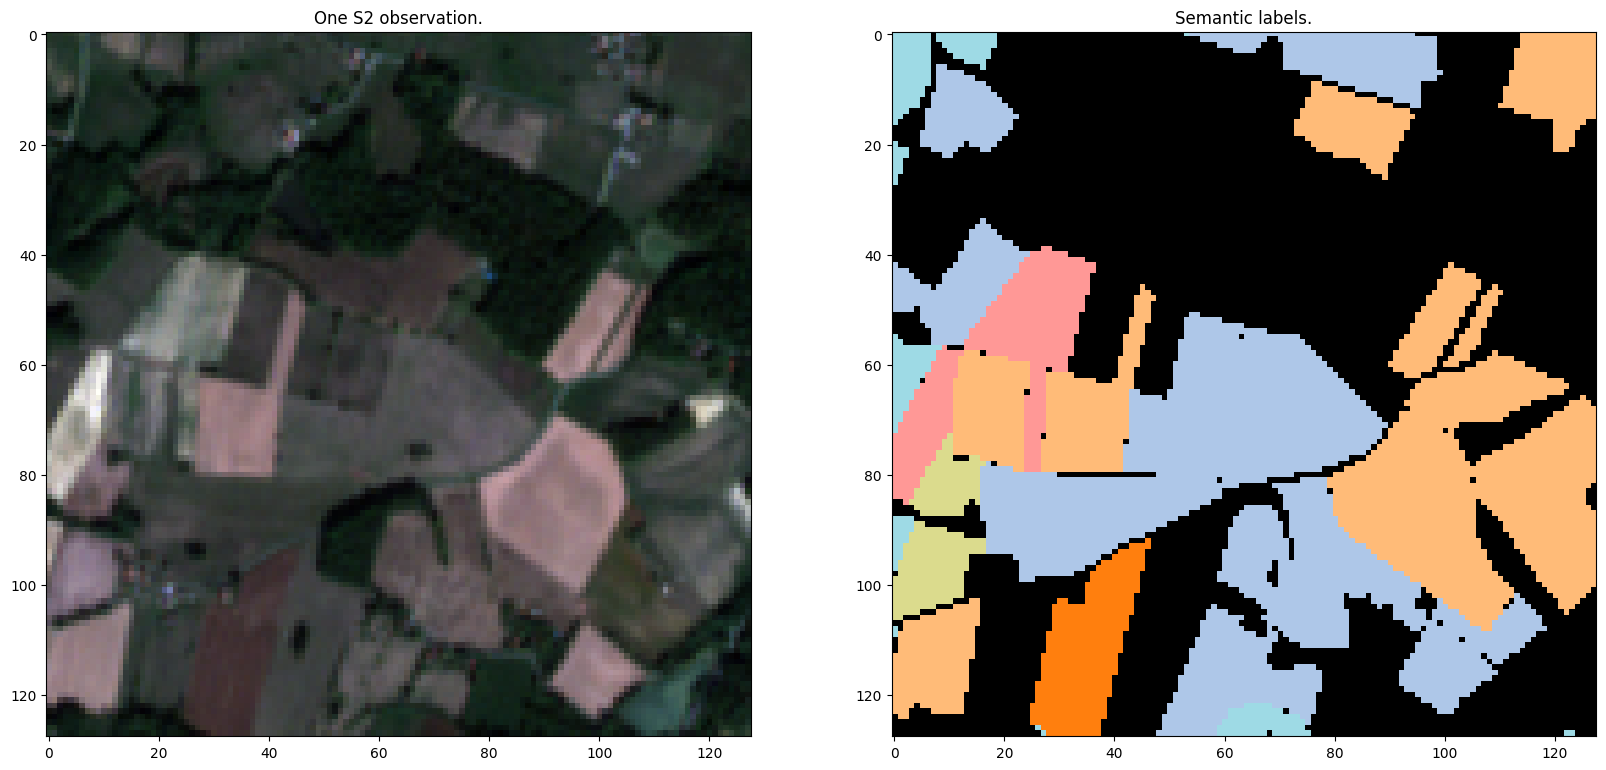

In [208]:
bid = 1 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
# axes[1].imshow(target_heatmap[bid].squeeze())
# axes[2].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
axes[1].imshow(y[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)
# print (pixel_semantic_annotation[bid].squeeze().shape)

axes[0].set_title('One S2 observation.')
# axes[1].set_title('Centerness Ground Truth.')
# axes[2].set_title('Instance masks.')
axes[1].set_title('Semantic labels.')

In [104]:
get_rgb(x, batch_index=bid).shape

(128, 128, 3)

In [105]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [176]:
x['S2'].view(x['S2'].shape[0], x['S2'].shape[1], x['S2'].shape[2], x['S2'].shape[3], x['S2'].shape[4]).shape

torch.Size([10, 61, 10, 128, 128])

In [180]:
x['S2'].numpy().flatten().shape

(99942400,)

In [210]:
y.view(y.shape[0], -1).shape

torch.Size([10, 16384])

In [220]:
np.repeat(y.numpy().flatten()[:, np.newaxis, np.newaxis], 610, axis=1).flatten()

(163840, 610)

In [217]:
# Flatten the time series
x_flat = x['S2'].numpy().flatten()

# Flatten the labels
y_flat = y.numpy().flatten()
y_flat = np.repeat(y_flat[:, np.newaxis], 610, axis=1)
y_flat = y_flat.flatten()

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_flat, y_flat, test_size=0.33, random_state=42)

#y_train = np.repeat(y_train[:, :, np.newaxis], x_train.shape[2], axis=2)

#x_train = x_train.reshape(x_train.shape[0], -1)
#y_train = y_train.reshape(y_train.shape[0], -1)
print(x_train.shape)
print(y_train.shape)

(66961408,)
(66961408,)


In [218]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

knn = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')

knn.fit(x_train, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.42597696  0.56987256  0.6094911  ... -0.07081087 -0.18029979
  0.6530976 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [136]:
y_pred = knn.predict(x_test)

In [143]:
y_test = np.repeat(y_test[:, np.newaxis], 610, axis=1)

In [146]:
y_test = y_test.reshape(-1)

In [147]:
y_test.shape

(39976960,)

In [158]:
# Evaluate
y_test = y_test.flatten()
y_pred = y_pred.flatten()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy: ', accuracy)
print('F1: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)

Accuracy:  0.369964599609375
F1:  0.3329579488112442
Precision:  0.3735883306991256
Recall:  0.369964599609375


In [162]:
x_test.shape

(4, 9994240)

In [191]:
x_output = x_test.reshape(4, 61, 10, 128, 128)
y_ground_output = y_test.reshape(128, 128, 10, 61, 4)
y_pred_output = y_pred.reshape(128, 128, 10, 61, 4)

In [186]:
y_pred_output[:, :, :, 0, 0].T.shape

(10, 128, 128)

In [188]:
get_rgb_from_np(y_pred_output[:, :, :, 0, 0].T).shape

(128, 128, 10)

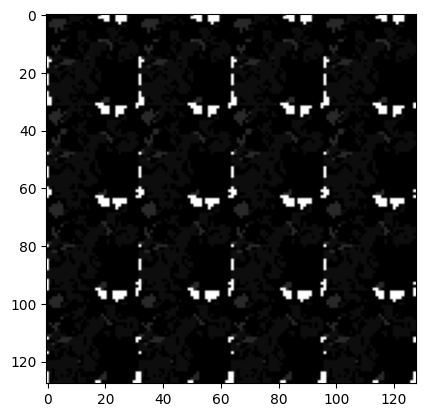

In [189]:
plt.imshow(get_rgb_from_np(y_pred_output[:, :, [2, 1, 0], 0, 0].T), cmap=cmap, vmin=0, vmax=20)

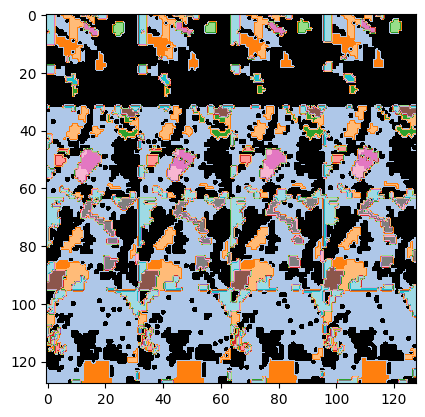

In [161]:
plt.imshow(y_ground_output[:, :, 0, 0], cmap=cmap, vmin=0, vmax=20)

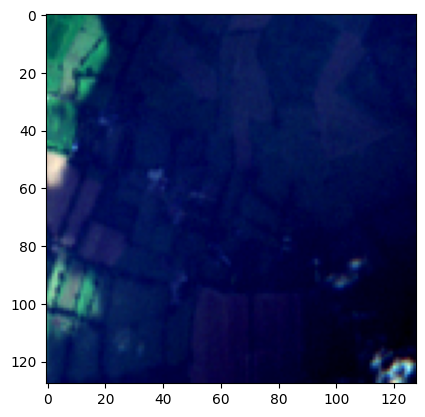

In [204]:
plt.imshow(get_rgb_from_np(x['S2'].numpy().flatten().reshape([10, 61, 10, 128, 128])[0, 0, [2, 1, 0], :,:]), cmap=cmap, vmin=0, vmax=20)

In [211]:
pred = knn.predict(x['S2'][0, 0, :, :, :].numpy().flatten())

ValueError: Expected 2D array, got 1D array instead:
array=[-0.41695225 -0.41290507 -0.38811597 ... -0.17877631  0.22585543
  0.45489225].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [122]:
# x_train=x_train.reshape([-1,3])
y_train=(y_train.reshape([-1,])).astype(np.int16)

print(x_train.shape)
print(y_train.shape)

svm = SVC(kernel='rbf', gamma='auto')
svm.fit(x_train, y_train)

(6, 9994240)
(6, 9994240)


ValueError: y should be a 1d array, got an array of shape (6, 9994240) instead.

In [ ]:
x_test = x_test.reshape(x_test.shape[0], -1)
y_pred = svm.predict(x_test)

In [ ]:
y_test = y_test.flatten()
y_pred = y_pred.flatten()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy: ', accuracy)
print('F1: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(y_test[:1000].reshape(10,100), cmap=cmap, vmin=0, vmax=20)

axes[1].imshow(y_pred[:1000].reshape(10,100), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('Ground Truth')

axes[1].set_title('Predictions')

plt.show()